In [1]:
########################################################################
# File            : $Id: $
# Version         : $Revision: 001 $
# Modified On     : $Date: 1st Feb 2022$
# Service version : 1.1.9
# Language        : Python/Jupyter

## Unsupervised Anomaly Detection in Univariate Time Series Data

This notebook is to showcase the IBM anomaly detection API services on 3 public datasets. The 3 public datasets are:

| Dataset                                                                                                              | Num of Records | Algorithm Used |
|----------------------------------------------------------------------------------------------------------------------|----------------|----------------|
| [ec2_network_in_5abac7](https://github.com/numenta/NAB/blob/master/data/realAWSCloudwatch/ec2_network_in_5abac7.csv) | 4718           | ReconstructAD  |
| [Twitter_volume_AAPL](https://github.com/numenta/NAB/blob/master/data/realTweets/Twitter_volume_AAPL.csv)            | 150902         | DeepAD         |
| [Bitcoin price](https://www.kaggle.com/mczielinski/bitcoin-historical-data)                                          | 30066          | PredAD         |

The workflow of this notebook is as follows: <br>

- Provide Credential
- for each datasets, 
    - Load Dataset
    - Compose Anomaly Service and Submit Job
    - Monitor Job
    - Result Analysis

### Credentials

This notebook requires two credentials. Please obtain your own credentials when customizing this notebook for your own work. Please visit __[Anomaly Detection @ IBM](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/Introduction)__ for trial subscription.

In [2]:
# Credentials required for running notebook

Client_ID = "replace-with-valid-client-ID"
Client_Secret = "replace-with-valid-client-Secret"


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import time
import json

## Experiment on ec2_network

### Load Dataset
The data is the time series of Amazon EC2 network bytes-in.

In [4]:
datafile_name = "ec2_network_in_5abac7.csv"
datafile_path = "./datasets/univariate/public_data/" + datafile_name
network_df = pd.read_csv(datafile_path)
network_df.head(10)

,timestamp,value
0,2014-03-01 17:36:00,42.0
1,2014-03-01 17:41:00,94.8
2,2014-03-01 17:46:00,42.0
3,2014-03-01 17:51:00,68.4
4,2014-03-01 17:56:00,68.4
5,2014-03-01 18:01:00,86.4
6,2014-03-01 18:06:00,68.4
7,2014-03-01 18:11:00,42.0
8,2014-03-01 18:16:00,112.8
9,2014-03-01 18:21:00,68.4


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c93f62c90>],
      dtype=object)

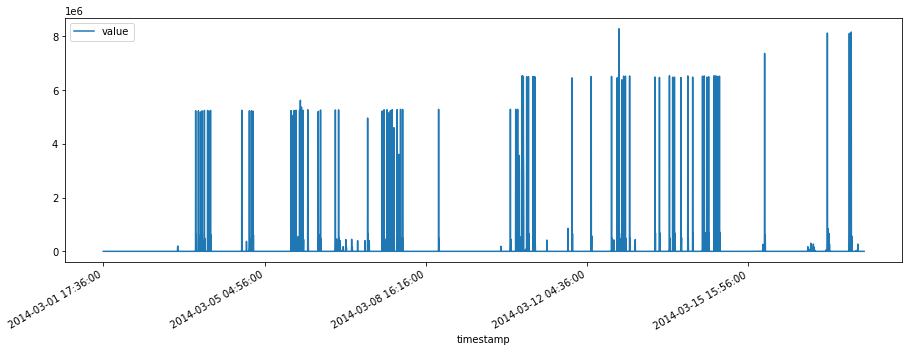

In [5]:
timestamp = 'timestamp'
value = 'value'
time_format = '%Y-%m-%d %H:%M:%S'
network_df.plot(x=timestamp, y=value, subplots=True, figsize=(15, 5))

### Anomaly Service Creation and Job Submission

Now, we compose anomaly service. User need to provide a local file name and some meta-data information about the data (target_column, time_column, time_format, algorithm_type, etc). The detail of these parameters are available at __[IBM API Hub @ IBM](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/api/API--ai4industry--anomaly-detection-api#batch_uni)__ for Univariate Anomaly detection service.

The Amazon EC-2 network data exhibits point anomalies which are sudden huge spikes in the normal operating data. The range of the values varies a lot under normal operation compared to anomalous operation. In this case, if a model were to learn the trend or pattern of the network data under normal operation, and attemp to reconstruct the signal, the spikes would not be reconstructed since they can be considered ‘outliers’. Thus, the ReconstructAD model would perform the best under these circumstances, which is demonstrated below.

In [6]:
files = {'data_file': (datafile_name, open(datafile_path, 'rb'))}

headers = {
    'X-IBM-Client-Id': Client_ID,
    'X-IBM-Client-Secret': Client_Secret,
    'accept': "application/json",
    }

data = {
    'target_column': value,
    'time_column': timestamp,
    'time_format': time_format,
    'prediction_type': 'entire',
    'algorithm_type': 'ReconstructAD',
    'lookback_window': 20,
    'observation_window': 20,
    'labeling_method': 'Chi-Square',
    'labeling_threshold': 10,
    'anomaly_estimator': 'CNN_AutoEncoder',
}

post_response = requests.post("https://api.ibm.com/ai4industry/run/anomaly-detection/timeseries/univariate/batch", 
                              data=data,
                              files=files,
                              headers=headers)

post_r_json = post_response.json()
anomaly_service_jobId = None
if 'jobId' in post_r_json:
    anomaly_service_jobId = post_r_json['jobId']
    print ('submitted successfully job : ', post_r_json['jobId'])
else:
    print (post_r_json)

submitted successfully job :  8aa28e5c-19a8-4d7f-8c77-999b6d23a74f


### Monitor Anomaly Job

Each anomaly detection service call generates one job id. We now track the progress of job. Detail of job execution is covered at __[Get Result](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/api/API--ai4industry--anomaly-detection-api#get_result_by_id)__. You may need to the following cell at periodic interval.

In [11]:
get_response = requests.get("https://api.ibm.com/ai4industry/run/result/" + anomaly_service_jobId, headers=headers)
json_data = get_response.json()

print("the status of job {} is {}.".format(anomaly_service_jobId, json_data['status']))

the status of job 8aa28e5c-19a8-4d7f-8c77-999b6d23a74f is done.


### Anomaly Results

Now we plot the anomaly score and anomaly label detected by the service. For anomaly labels, '1' signifies that these samples at that time points are normals; '-1' means these samples are outliers or anomalous.

In the plots, the first graph plots the original data and the predicted anomalies. The second graph plots the anomaly scores.

In [12]:
def plot_anomalies(result, data_df):
    anomaly_scores = []
    anomaly_labels = []
    for item in result:
        anomaly_scores.append(item['value']['anomaly_score'][0])
        anomaly_labels.append(item['value']['anomaly_label'][0])
    plot_data_df = data_df.copy()
    plot_data_df['anomaly_label'] = anomaly_labels
    plot_data_df['anomaly_score'] = anomaly_scores
    label_df = plot_data_df.loc[plot_data_df['anomaly_label'] == -1.0, (timestamp, value)]
    fig, ax = plt.subplots(2, sharex=True,constrained_layout=True, figsize=(15,10))
    # the x axis is indices because it takes forever to plot results with timestamp as x axis
    ax[0].plot(plot_data_df.index, plot_data_df[value], label='timeseries data')
    ax[0].scatter(label_df.index,label_df[value], color='red', label='anomaly')
    ax[1].plot(plot_data_df.index, plot_data_df['anomaly_score'], color='green', label='anomaly score')
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    plt.show()


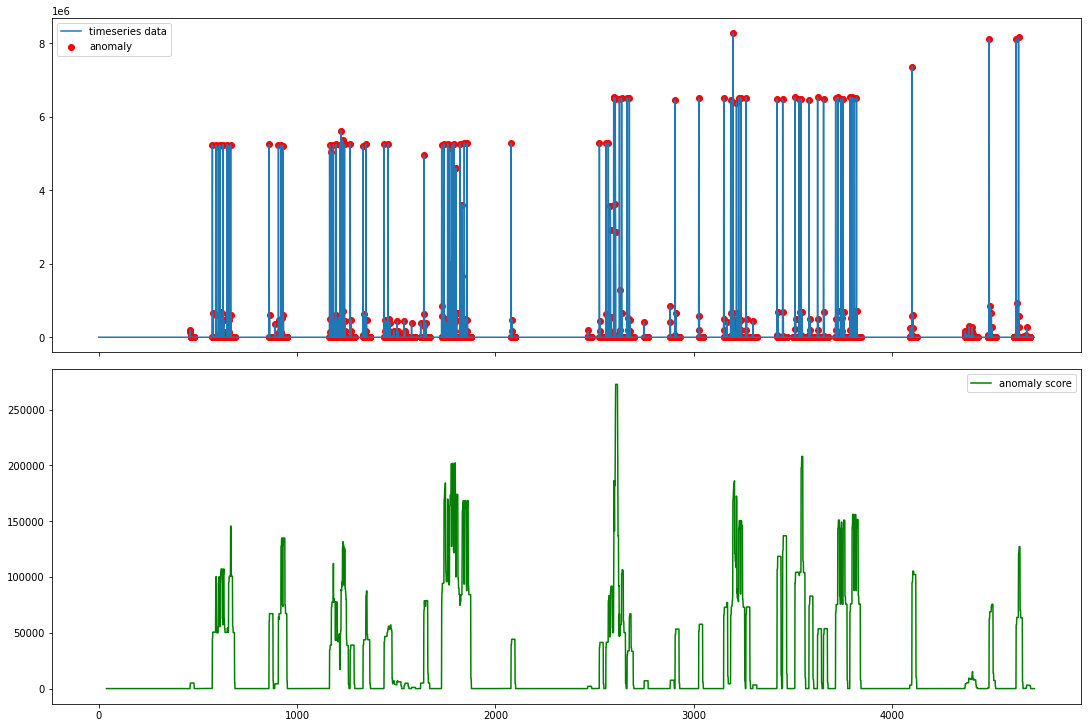

In [13]:
if json_data['status'] == 'done':
    plot_anomalies(json_data['summary']['result'], network_df)
else:
    print('the job {} is not done yet.'.format(anomaly_service_jobId))

## Experiment on Twitter Volume
### Load Dataset
The data is the time series of Tweet volume data for ticker $APPL.

In [14]:
datafile_name = "Twitter_volume_AAPL.csv"
datafile_path = "./datasets/univariate/public_data/" + datafile_name
twitter_df = pd.read_csv(datafile_path)
twitter_df.head(10)

,timestamp,value
0,2015-02-26 21:42:53,104
1,2015-02-26 21:47:53,100
2,2015-02-26 21:52:53,99
3,2015-02-26 21:57:53,154
4,2015-02-26 22:02:53,120
5,2015-02-26 22:07:53,90
6,2015-02-26 22:12:53,92
7,2015-02-26 22:17:53,71
8,2015-02-26 22:22:53,339
9,2015-02-26 22:27:53,178


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c9455ec50>],
      dtype=object)

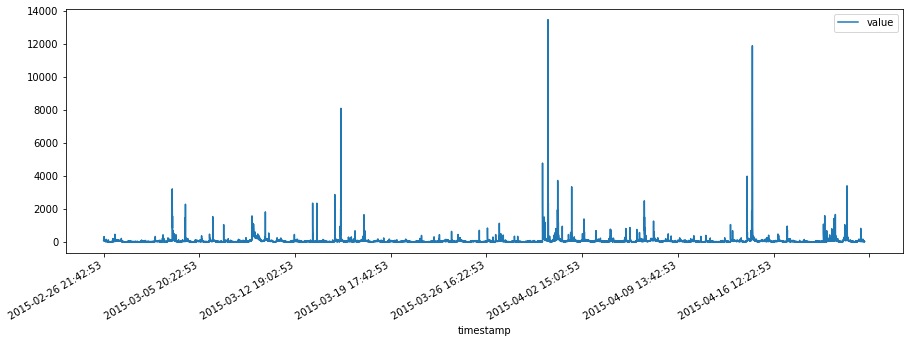

In [15]:
timestamp = "timestamp"
value = "value"
time_format = '%Y-%m-%d %H:%M:%S'
twitter_df.plot(x=timestamp, y=value, subplots=True, figsize=(15, 5))

### Anomaly Service Creation and Job Submission
The twitter volume data exhibits high spikes during abnormal behavior, however, the anomalies are localized. We can note that the data spikes a bit more gradually than the EC2 network data, where in this case, the data gradually increases in amplitude and then experiences a sudden spike. In this case, the 'Contextual-Anomaly' scoring method would perform the best since we are looking for localized spike-based anomalies. The DeepAD model considers multiple model options to generate the best scoring model for this particular data.

In [16]:
files = {'data_file': (datafile_name, open(datafile_path, 'rb'))}

data = {
    'target_column': value,
    'time_column': timestamp,
    'time_format': time_format,
    'prediction_type': 'entire',
    'algorithm_type': 'DeepAD',
    'lookback_window': 'auto',
    'observation_window': 50,
    'labeling_method': 'Contextual-Anomaly',
    'labeling_threshold': 10,
    'anomaly_estimator': 'Default',
}

post_response = requests.post("https://api.ibm.com/ai4industry/run/anomaly-detection/timeseries/univariate/batch", 
                              data=data,
                              files=files,
                              headers=headers)

post_r_json = post_response.json()
anomaly_service_jobId = None
if 'jobId' in post_r_json:
    anomaly_service_jobId = post_r_json['jobId']
    print ('submitted successfully job : ', post_r_json['jobId'])
else:
    print (post_r_json)

submitted successfully job :  26c20b55-49c1-4b1c-a8e4-b5feb0a457a5


### Monitor Anomaly Job

In [19]:
get_response = requests.get("https://api.ibm.com/ai4industry/run/result/" + anomaly_service_jobId, headers=headers)
json_data = get_response.json()

print("the status of job {} is {}.".format(anomaly_service_jobId, json_data['status']))

the status of job 26c20b55-49c1-4b1c-a8e4-b5feb0a457a5 is done.


### Anomaly Results

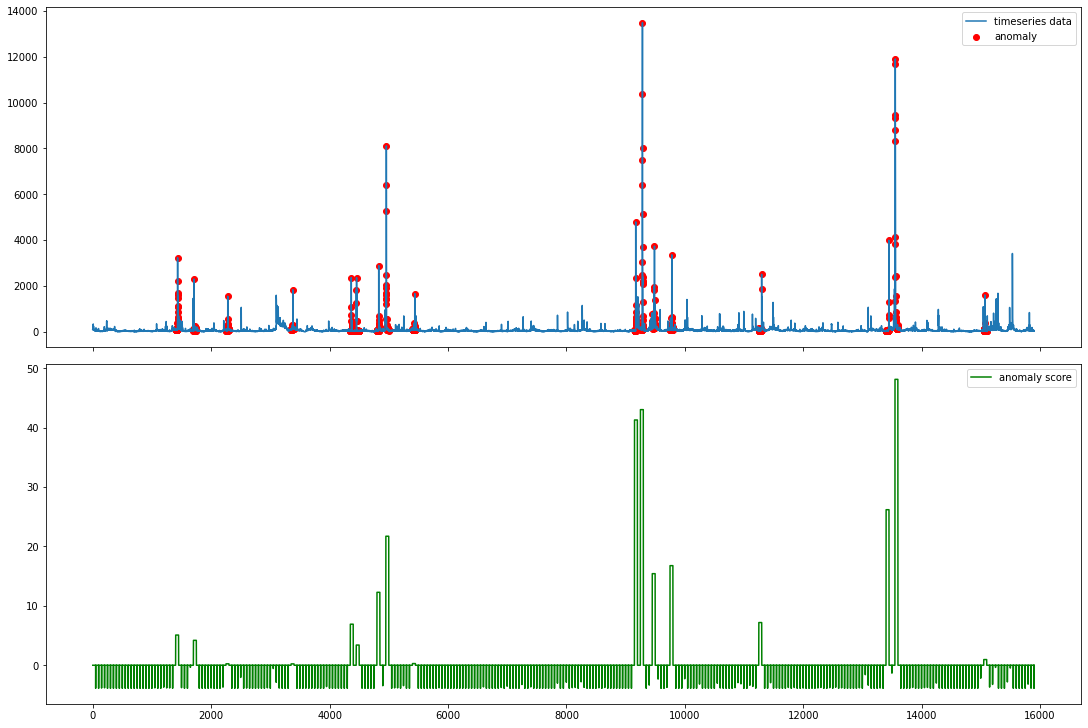

In [20]:
if json_data['status'] == 'done':
    plot_anomalies(json_data['summary']['result'], twitter_df)
else:
    print('the job {} is not done yet.'.format(anomaly_service_jobId))

## Experiment on Bitcoin price
### Load Dataset
The data is the historical bitcoin price in USD. The [raw data](https://www.kaggle.com/mczielinski/bitcoin-historical-data) has prices in minutes. In order to shorten the data, we preprocess the data by the following steps:
1. resample the data to hourly data
2. select data from 2017-10-25 to 2021-03-31
3. impute missing prices by backward filling

The processed data can be loaded directly from `./datasets/univariate/public_data/`

In [21]:
datafile_name = "bitcoin_20171025_20210331.csv"
datafile_path = "./datasets/univariate/public_data/" + datafile_name

timestamp = "Timestamp"
value = "Weighted_Price"
time_format = '%Y-%m-%d %H:%M:%S'

bitcoin_df = pd.read_csv(datafile_path)

bitcoin_df.head(10)

,Timestamp,Weighted_Price
0,2017-10-25 07:00:00,5566.168248
1,2017-10-25 08:00:00,5609.117907
2,2017-10-25 09:00:00,5618.544111
3,2017-10-25 10:00:00,5585.530009
4,2017-10-25 11:00:00,5516.217082
5,2017-10-25 12:00:00,5484.641891
6,2017-10-25 13:00:00,5522.335430
7,2017-10-25 14:00:00,5517.409590
8,2017-10-25 15:00:00,5466.962502
9,2017-10-25 16:00:00,5520.523230


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c9532e510>],
      dtype=object)

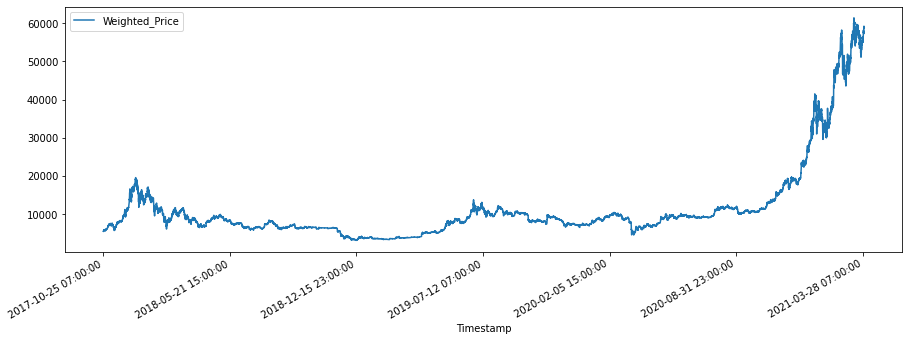

In [22]:
bitcoin_df.plot(x=timestamp, y=value, subplots=True, figsize=(15, 5))

### Anomaly Service Creation and Job Submission
The bitcoin price data exhibits trend-based anomalies. It may fluctuate, increase and decrease frequently but occasionaly there may be highs and lows in the data compared to neighboring values. The data can be anomalous for a few minutes/hours - i.e. for a region of timestamps. This is also considered as a 'contextual' anomaly, and thus that is the best scoring method for this kind of data. Here, the 'PredAD' model performs well, since a prediction-based anomaly detection model would be able to find the differences clearly in trends that are deviating from normal operation.

In [23]:
files = {'data_file': (datafile_name, open(datafile_path, 'rb'))}

data = {
    'target_column': value,
    'time_column': timestamp,
    'time_format': time_format,
    'prediction_type': 'entire',
    'algorithm_type': 'PredAD',
    'lookback_window': 100,
    'observation_window': 100,
    'labeling_method': 'Contextual-Anomaly',
    'labeling_threshold': 10,
    'anomaly_estimator': 'Default',
}

post_response = requests.post("https://api.ibm.com/ai4industry/run/anomaly-detection/timeseries/univariate/batch", 
                              data=data,
                              files=files,
                              headers=headers)

post_r_json = post_response.json()
anomaly_service_jobId = None
if 'jobId' in post_r_json:
    anomaly_service_jobId = post_r_json['jobId']
    print ('submitted successfully job : ', post_r_json['jobId'])
else:
    print (post_r_json)

submitted successfully job :  6c4282ff-5591-4a29-80d4-77271fe88705


### Monitor Anomaly Job

In [25]:
get_response = requests.get("https://api.ibm.com/ai4industry/run/result/" + anomaly_service_jobId, headers=headers)
json_data = get_response.json()

print("the status of job {} is {}.".format(anomaly_service_jobId, json_data['status']))

the status of job 6c4282ff-5591-4a29-80d4-77271fe88705 is done.


### Anomaly Results

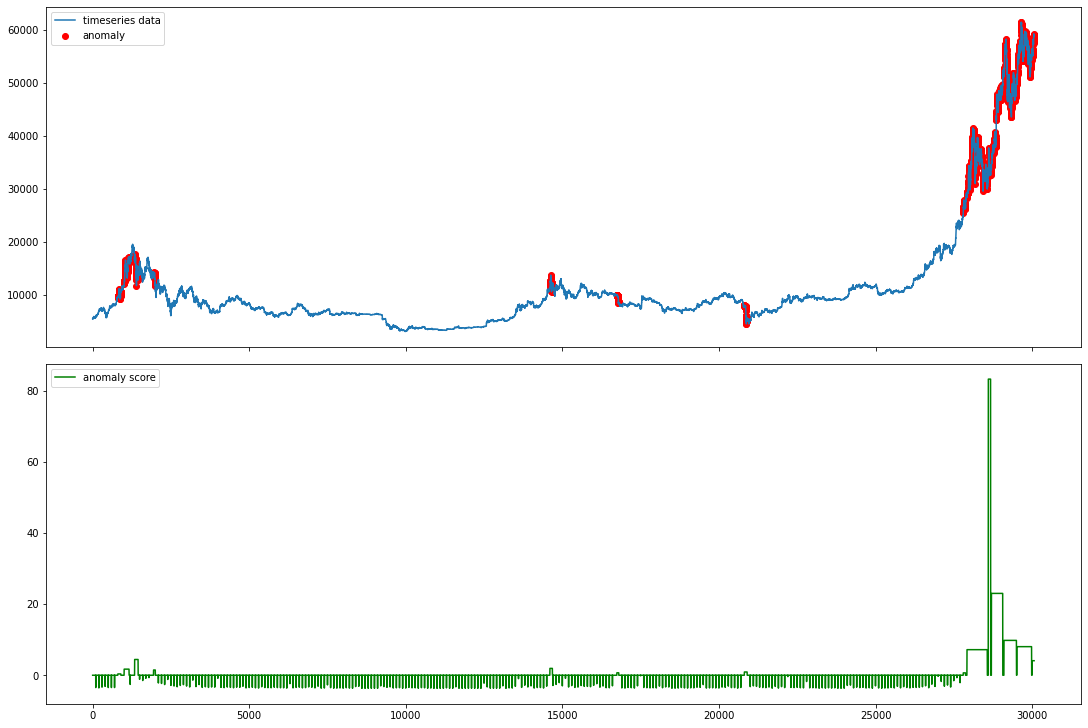

In [26]:
if json_data['status'] == 'done':
    plot_anomalies(json_data['summary']['result'], bitcoin_df)
else:
    print('the job {} is not done yet.'.format(anomaly_service_jobId))